## This python script will train a MobileNet model to recognize Starcraft 2 Units

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,array_to_img
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import load_model
from keras.applications.mobilenetv2 import MobileNetV2
import os
import pickle
from keras.models import model_from_json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
target_size = 256

CLASSES = sorted(os.listdir(".\\cropped images\\Training-Data"))

def build_model():
    ''' This function will build a MobileNetV2 Model to be used for our classifier'''
    input_tensor = Input(shape=(target_size, target_size, 3))
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        pooling='avg')

    for layer in base_model.layers:
        layer.trainable = True  # trainable has to be false in order to freeze the layers
        
    op = Dense(256, activation='relu')(base_model.output)
    op = Dropout(.25)(op)
    # A single output because we are only trying to predict a single class
    output_tensor = Dense(len(CLASSES), activation='softmax')(op)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    return model

In [3]:
model = build_model()
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.nadam(lr=0.00001),
              metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Orchard\.conda\envs\tensorflow_env\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30,
                                   vertical_flip=True,
                                   validation_split=0.3)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_set = train_datagen.flow_from_directory(
    '.\\cropped images\\Training-Data',
    target_size=(target_size,target_size),
    class_mode="categorical",
    shuffle=True,
    batch_size=8,
    subset="training")

validation_set = train_datagen.flow_from_directory(
    '.\\cropped images\\Training-Data',
    target_size=(target_size,target_size),
    class_mode="categorical",
    shuffle=True,
    batch_size=8,
    subset="validation")

test_set = test_datagen.flow_from_directory(
    '.\\cropped images\\Test-Data',
    target_size=(target_size,target_size),
    class_mode="categorical",
    shuffle=True,
    batch_size=1)

Found 604 images belonging to 31 classes.
Found 238 images belonging to 31 classes.
Found 179 images belonging to 18 classes.


In [5]:
model.fit_generator(training_set,
                          steps_per_epoch=800,
                          epochs=25,
                          validation_data=validation_set,
                          validation_steps=200)
model.summary()

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
800/800 [==============================] - 128s 159ms/step - loss: 2.0658 - acc: 0.4752 - val_loss: 1.1581 - val_acc: 0.6732
Epoch 2/25
800/800 [==============================] - 122s 153ms/step - loss: 1.2582 - acc: 0.6778 - val_loss: 0.7606 - val_acc: 0.8008
Epoch 3/25
800/800 [==============================] - 123s 154ms/step - loss: 0.9387 - acc: 0.7567 - val_loss: 0.5097 - val_acc: 0.8613
Epoch 4/25
800/800 [==============================] - 123s 154ms/step - loss: 0.7157 - acc: 0.8063 - val_loss: 0.3807 - val_acc: 0.8898
Epoch 5/25
800/800 [==============================] - 124s 155ms/step - loss: 0.5801 - acc: 0.8419 - val_loss: 0.2772 - val_acc: 0.9161
Epoch 6/25
800/800 [==============================] - 124s 155ms/step - loss: 0.4712 - acc: 0.8713 - val_loss: 0.2205 - val_acc: 0.9325
Epoch 7/25
800/800 [==============================] - 124s 156ms/step - loss: 0.3725 - acc: 0.8925 - val_loss: 0.1903 - val_acc: 0.9433


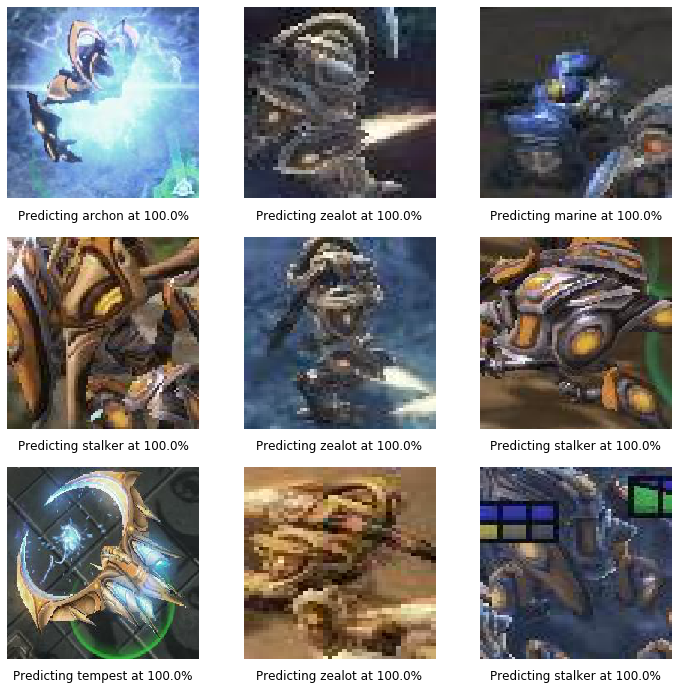

In [22]:
prediction_results = model.predict_generator(test_set,steps=1)
CLASSES = sorted(os.listdir(".\\cropped images\\Test-Data"))
fig = plt.figure(figsize=(12, 12))
plt.tight_layout()
for i in range(1,10):
    a = fig.add_subplot(3, 3, i)
    batch_x, batch_y = test_set.next()
    predicted_unit = np.argmax(batch_y)
    a.set_title(f'Predicting {CLASSES[predicted_unit]} at {round(np.max(batch_y)*100,2)}%', y=-.14)
    plt.imshow(array_to_img(batch_x[0]))
    plt.axis('off')

In [12]:
model_json=model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("weights_VGG.h5")
model.save("model_27.h5")
